In [5]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
from networkx.algorithms import community, centrality
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline 
from datetime import datetime, timedelta
from datetime import date
import powerlaw
from collections import defaultdict, Counter
from networkx.algorithms import community
from networkx.algorithms import bipartite
from networkx.algorithms import centrality as ce
from networkx.algorithms import community as c

In [6]:
file= 'data/Investments.xlsx'
df = pd.read_excel(file)

### Preprocess

In [7]:
df = df[['company_name','company_market','investor_name','funded_year','raised_amount_usd']]
df.rename(columns = {'company_name' : 'Company_Name', 'company_market' : 'Company_Market', 'investor_name':'Investor_Name', 'funded_year':'Funded_Year', 'raised_amount_usd':'Raised_Amount_USD'}, inplace = True)
df = df.dropna()
df = df[df.Raised_Amount_USD != 0]
df = df[df.Funded_Year>=1990]

In [8]:
df.head()

,Company_Name,Company_Market,Investor_Name,Funded_Year,Raised_Amount_USD
31,Knowledge Adventure,Games,William Lohse,1990,60000.0
43,Market Wire,Advertising,Hummer Winblad Venture Partners,1990,17550000.0
44,Market Wire,Advertising,Mindful Investors,1990,17550000.0
45,Market Wire,Advertising,Montreux Equity Partners,1990,17550000.0
46,Market Wire,Advertising,Osprey Ventures,1990,17550000.0


In [9]:
df.shape

(99090, 5)

### Data exploration

In [10]:
print(f"Number of unique investors: {df['Investor_Name'].nunique()}")
print(f"Number of unique companies: {df['Company_Name'].nunique()}")
print(f"Number of unique company markets: {df['Company_Market'].nunique()}")
print(f"Number of unique years: {df['Funded_Year'].nunique()}")

Number of unique investors: 20156
Number of unique companies: 24908
Number of unique company markets: 695
Number of unique years: 23


### Building the network

In [11]:
G_weighted_directed = nx.from_pandas_edgelist(df=df,source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
nodes = pd.DataFrame(list(G_weighted_directed.nodes))
print(nx.info(G_weighted_directed))

Name: 
Type: MultiDiGraph
Number of nodes: 44777
Number of edges: 99090
Average in degree:   2.2130
Average out degree:   2.2130


#### Split the data by years

In [12]:
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]
# Split the data to years
df_list =[df[(df['Funded_Year'] <= year_range[1]) & (df['Funded_Year'] >= year_range[0])] for year_range in years_range]

Name: 
Type: MultiDiGraph
Number of nodes: 14250
Number of edges: 28455
Average in degree:   1.9968
Average out degree:   1.9968
defaultdict(<class 'int'>, {85: 1, 16: 56, 202: 1, 8: 312, 9: 236, 14: 66, 2: 2447, 61: 2, 11: 145, 23: 18, 4: 941, 18: 38, 10: 151, 47: 2, 94: 2, 97: 1, 41: 4, 69: 4, 5: 701, 77: 1, 19: 26, 3: 1466, 86: 1, 159: 1, 13: 82, 6: 520, 17: 32, 1: 6155, 111: 2, 15: 65, 35: 3, 12: 116, 255: 2, 37: 7, 26: 6, 7: 377, 109: 1, 52: 2, 40: 6, 22: 23, 95: 2, 119: 1, 20: 19, 53: 2, 66: 2, 81: 1, 43: 4, 34: 3, 49: 3, 83: 3, 29: 11, 65: 1, 25: 12, 93: 1, 30: 11, 39: 7, 112: 1, 51: 5, 46: 2, 48: 4, 256: 1, 59: 2, 120: 1, 38: 4, 63: 1, 24: 9, 50: 3, 36: 3, 31: 4, 27: 11, 33: 3, 45: 6, 168: 1, 42: 4, 75: 2, 218: 1, 32: 10, 102: 1, 116: 1, 114: 1, 88: 1, 21: 28, 58: 1, 104: 1, 54: 2, 98: 1, 44: 4, 80: 2, 106: 1, 117: 1, 28: 16, 72: 1, 133: 1, 68: 1, 56: 1, 60: 1, 82: 1})


Text(0.5, 1.0, 'Number of nodes vs Number of edges')

<Figure size 432x288 with 0 Axes>

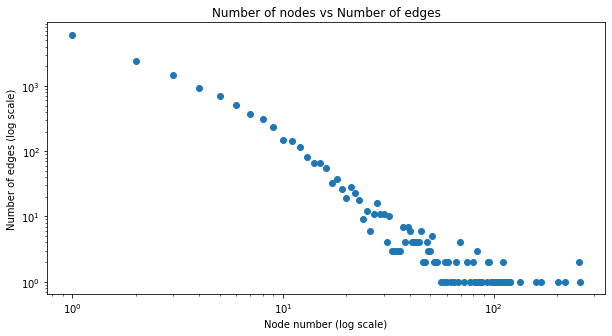

In [13]:
G_weighted_directed = nx.from_pandas_edgelist(df=df_list[3],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())

nodes = pd.DataFrame(list(G_weighted_directed.nodes))
print(nx.info(G_weighted_directed))
#degree_hist = nx.degree_histogram(G_weighted_directed)
degrees = [G_weighted_directed.degree(n) for n in G_weighted_directed.nodes()]
#print(sorted(G_weighted_directed.degree, key=lambda x: x[1], reverse=True))

degs = defaultdict(int)
for node, deg in G_weighted_directed.degree:
    degs[deg] +=1
print(degs)
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(degs.keys(), degs.values())
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Node number (log scale)")
ax.set_ylabel("Number of edges (log scale)")
ax.set_title("Number of nodes vs Number of edges")

In [16]:
indegree = dict(G_weighted_directed.in_degree)
outdegree = dict(G_weighted_directed.out_degree)
# print(degree)

{'William Lohse': 9, 'Knowledge Adventure': 0, 'Hummer Winblad Venture Partners': 96, 'Market Wire': 0, 'Mindful Investors': 12, 'Montreux Equity Partners': 24, 'Osprey Ventures': 7, 'Perkins Coie': 4, 'Sequoia Capital': 693, 'Stanford University': 32, 'Motorola Solutions Venture Capital': 82, 'Viewpoint Digital': 0, 'Hummer Winblad': 1, 'Intel': 22, 'Kleiner Perkins Caufield & Byers': 531, 'eXeed Technology': 6, 'ActionBase': 0, 'IDG Capital Partners': 197, 'Infotop': 0, 'Edmond de Rothschild Venture Capital': 36, 'MediaLink': 0, 'CMGI @Ventures': 3, 'GeoCities': 0, 'Yahoo!': 14, 'Amazon': 22, 'Reuters': 2, 'SoftBank': 17, 'AOL': 6, 'XO Group': 1, 'Flatiron Partners': 6, 'Shamrock Holdings': 4, 'Orad': 0, 'Smedvig Capital': 26, 'TreFoil Energy': 0, 'Steps Ventures': 1, 'PowerDsine': 0, 'SAIF Partners': 110, 'UTStarcom': 2, 'Montgomery & Co': 4, 'Digital Media Broadcast': 0, 'Mtone Wireless': 0, 'WI Harper Group': 57, 'CIBC World Markets': 9, 'Global Crossing': 0, 'Benchmark': 323, 'eB

Calculating best minimal value for power law fit
gamma= 2.512713053215986


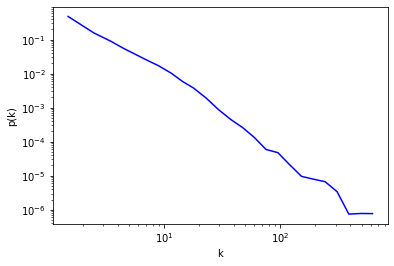

In [54]:
degree_sequence = sorted([d for _, d in G_weighted_directed.degree()],reverse=True)
figPDF = powerlaw.plot_pdf(degree_sequence,color='b')
figPDF.set_ylabel(r"p(k)")
figPDF.set_xlabel(r"k")
fit = powerlaw.Fit(degree_sequence,discrete=True)
gamma = fit.power_law.alpha
print("gamma=",gamma)

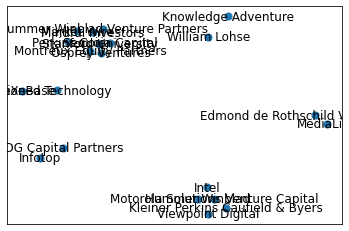

In [55]:
# Plot directional Graph

# G = nx.MultiDiGraph()
# edges = [df_list[3]]
G = nx.from_pandas_edgelist(df=df_list[0],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 50)
nx.draw_networkx_labels(G, pos)
plt.show()

Graphs - number of edges
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]

{'(1990, 1994)': 15, '(1995, 1999)': 233, '(2000, 2004)': 1635, '(2005, 2009)': 28455, '(2010, 2014)': 68752}


Text(0.5, 1.0, 'Year Range vs Number of Edges')

<Figure size 432x288 with 0 Axes>

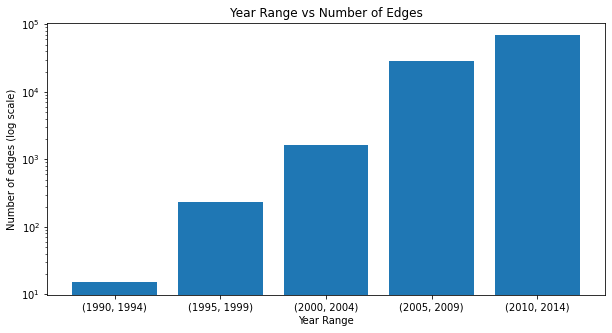

In [56]:
graph_list = [nx.from_pandas_edgelist(df_list[i],source='Investor_Name',target='Company_Name', edge_attr='Raised_Amount_USD', create_using=nx.MultiDiGraph()) for i, _ in enumerate(years_range)]

# G90_94 = nx.from_pandas_edgelist(df=df_list[0],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
# G95_99 = nx.from_pandas_edgelist(df=df_list[1],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
# G00_04 = nx.from_pandas_edgelist(df=df_list[2],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
# G05_09 = nx.from_pandas_edgelist(df=df_list[3],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
# G10_14 = nx.from_pandas_edgelist(df=df_list[4],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())

edge_number_histogram = {str(year_range):graph_list[i].number_of_edges() for i, year_range  in enumerate(years_range)}

print(edge_number_histogram)

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(edge_number_histogram.keys(), edge_number_histogram.values())
ax.set_xlabel("Year Range")
ax.set_yscale('log')
ax.set_ylabel("Number of edges (log scale)")
ax.set_title("Year Range vs Number of Edges")


Text(0.5, 1.0, 'Year Range vs Number of Nodes')

<Figure size 432x288 with 0 Axes>

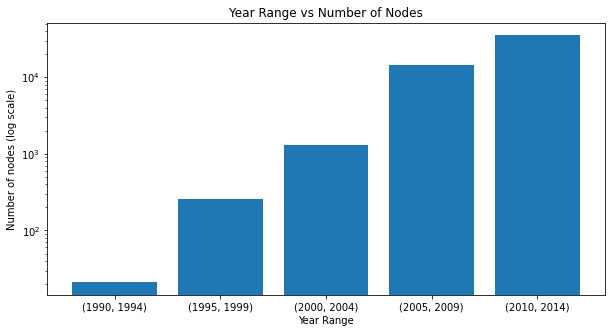

In [57]:
node_number_histogram = {str(year_range):graph_list[i].number_of_nodes() for i, year_range  in enumerate(years_range)}
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(node_number_histogram.keys(), node_number_histogram.values())
ax.set_xlabel("Year Range")
ax.set_yscale('log')
ax.set_ylabel("Number of nodes (log scale)")
ax.set_title("Year Range vs Number of Nodes")

In [58]:
graph_list[0].edges


OutMultiEdgeView([('William Lohse', 'Knowledge Adventure', 0), ('Hummer Winblad Venture Partners', 'Market Wire', 0), ('Mindful Investors', 'Market Wire', 0), ('Montreux Equity Partners', 'Market Wire', 0), ('Osprey Ventures', 'Market Wire', 0), ('Perkins Coie', 'Market Wire', 0), ('Sequoia Capital', 'Market Wire', 0), ('Stanford University', 'Market Wire', 0), ('Motorola Solutions Venture Capital', 'Viewpoint Digital', 0), ('Hummer Winblad', 'Viewpoint Digital', 0), ('Intel', 'Viewpoint Digital', 0), ('Kleiner Perkins Caufield & Byers', 'Viewpoint Digital', 0), ('eXeed Technology', 'ActionBase', 0), ('IDG Capital Partners', 'Infotop', 0), ('Edmond de Rothschild Venture Capital', 'MediaLink', 0)])

In [59]:
graph_list[0].get_edge_data('William Lohse', 'Knowledge Adventure')

{0: {'Raised_Amount_USD': 60000.0}}

In [60]:

def get_in_out_nodes(g, investors:pd.DataFrame, company_name: pd.DataFrame):
    """
    Split degrees to companies and investors (inbound, outbound)
    :param g: graph
    :param investors: investors DF
    :param company_name: comapnies DF
    """
   
    all_degrees = dict(g.degree)
    in_nodes = defaultdict(int)
    out_nodes = defaultdict(int)

    for company, n_edges in all_degrees.items():
        if company in investors.values:
            out_nodes[company] = n_edges
        elif company in company_name.values:
            in_nodes[company] = n_edges

    print("Invested in companies (inbound)")
    print(dict(in_nodes))
    print("\n")
    print("Investing companies (outbound)")
    print(dict(out_nodes))
    return in_nodes, out_nodes

def avg_degree(nodes:dict):
    """
    Calculate the average degree of the nodes in the graph
    :param nodes: dictionary of node_name(str): degree(int)
    """
    return sum([degree for degree in nodes.values()]) / len(nodes)

g = graph_list[0]
investing_companies = df_list[0]['Investor_Name']
invested_companies = df_list[0]['Company_Name']
inbound, outbound = get_in_out_nodes(g, investing_companies, invested_companies)
print(avg_degree(inbound))
print(avg_degree(outbound))


Invested in companies (inbound)
{'Knowledge Adventure': 1, 'Market Wire': 7, 'Viewpoint Digital': 4, 'ActionBase': 1, 'Infotop': 1, 'MediaLink': 1}


Investing companies (outbound)
{'William Lohse': 1, 'Hummer Winblad Venture Partners': 1, 'Mindful Investors': 1, 'Montreux Equity Partners': 1, 'Osprey Ventures': 1, 'Perkins Coie': 1, 'Sequoia Capital': 1, 'Stanford University': 1, 'Motorola Solutions Venture Capital': 1, 'Hummer Winblad': 1, 'Intel': 1, 'Kleiner Perkins Caufield & Byers': 1, 'eXeed Technology': 1, 'IDG Capital Partners': 1, 'Edmond de Rothschild Venture Capital': 1}
2.5
1.0


In [61]:
print(centrality.degree_centrality(g))
print(centrality.in_degree_centrality(g))
print(centrality.out_degree_centrality(g))

{'William Lohse': 0.05, 'Knowledge Adventure': 0.05, 'Hummer Winblad Venture Partners': 0.05, 'Market Wire': 0.35000000000000003, 'Mindful Investors': 0.05, 'Montreux Equity Partners': 0.05, 'Osprey Ventures': 0.05, 'Perkins Coie': 0.05, 'Sequoia Capital': 0.05, 'Stanford University': 0.05, 'Motorola Solutions Venture Capital': 0.05, 'Viewpoint Digital': 0.2, 'Hummer Winblad': 0.05, 'Intel': 0.05, 'Kleiner Perkins Caufield & Byers': 0.05, 'eXeed Technology': 0.05, 'ActionBase': 0.05, 'IDG Capital Partners': 0.05, 'Infotop': 0.05, 'Edmond de Rothschild Venture Capital': 0.05, 'MediaLink': 0.05}
{'William Lohse': 0.0, 'Knowledge Adventure': 0.05, 'Hummer Winblad Venture Partners': 0.0, 'Market Wire': 0.35000000000000003, 'Mindful Investors': 0.0, 'Montreux Equity Partners': 0.0, 'Osprey Ventures': 0.0, 'Perkins Coie': 0.0, 'Sequoia Capital': 0.0, 'Stanford University': 0.0, 'Motorola Solutions Venture Capital': 0.0, 'Viewpoint Digital': 0.2, 'Hummer Winblad': 0.0, 'Intel': 0.0, 'Kleiner 